In [1]:
# %pip install torch

  Using cached torch-2.9.1-cp313-none-macosx_11_0_arm64.whl.metadata (30 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.10.0-py3-none-any.whl.metadata (10 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached torch-2.9.1-cp313-none-macosx_11_0_arm64.whl (74.5 MB)
Using cached fsspec-2025.10.0-py3-none-any.whl (200 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.0 MB/s eta 0:00:00
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached filelock-3.20.0-py3-none-any.whl (16 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)

[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import(
    roc_auc_score,
    log_loss,
    average_precision_score,
    brier_score_loss,
    accuracy_score
)

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.grid"] = True

DEVICE = torch.device("mps" if torch.mps.is_available() else "cpu")
DEVICE

device(type='mps')

In [4]:
DATA_PATH = Path("data/processed/ad_events_processed.csv")
df = pd.read_csv(DATA_PATH)
df.head()

,user_id,ad_id,user_age_bucket,user_location,user_device,user_base_ctr,ad_category,ad_quality_score,ad_base_ctr,bid,time_of_day,interest_match,true_ctr,clicked
0,46993,646,35-44,Tier-3,android,0.031010,fashion,0.852224,0.037387,1.79,morning,0,0.600000,1
1,15268,707,25-34,Tier-2,android,0.039462,electronics,0.588347,0.025422,4.95,evening,0,0.575525,1
2,65066,552,35-44,Tier-2,android,0.023422,fashion,0.818090,0.052376,3.24,morning,0,0.600000,0
3,26740,640,25-34,Tier-2,ios,0.047996,electronics,0.838686,0.040108,2.28,evening,0,0.600000,1
4,69272,643,25-34,Tier-2,ios,0.054098,electronics,0.711505,0.041477,4.70,evening,0,0.600000,1


In [5]:
df["clicked"].mean(), df.shape

(np.float64(0.5737585), (2000000, 14))

In [6]:
target_col = "clicked"

feature_cols = [
    "user_id",
    "ad_id",
    "user_age_bucket",
    "user_location",
    "user_device",
    "user_base_ctr",
    "ad_category",
    "ad_quality_score",
    "ad_base_ctr",
    "bid",
    "time_of_day",
    "interest_match",
]

X = df[feature_cols].copy()
y = df[target_col].astype(int).values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

X_train.shape, X_val.shape, X_test.shape

((1400000, 12), (300000, 12), (300000, 12))

##### Embedding vs Numerical Features

In [7]:
id_features = ["user_id","ad_id"]

categorical_features = [
    "user_age_bucket",
    "user_location",
    "user_device",
    "ad_category",
    "time_of_day",
]

numeric_features = [
    "user_base_ctr",
    "ad_quality_score",
    "ad_base_ctr",
    "bid",
    "interest_match",
]

In [11]:
def build_vocab(series: pd.Series):
    uniques = series.astype("category").cat.categories.tolist()
    stoi = {v: i for i,v in enumerate(uniques)}
    return stoi, uniques


vocab = {}

user_stoi, user_uniques = build_vocab(X_train["user_id"])
vocab["user_id"] = user_stoi
n_users = len(user_uniques)


ad_stoi, ad_uniques = build_vocab(X_train["ad_id"])
vocab["ad_id"] = ad_stoi
n_ads = len(ad_uniques)

for col in categorical_features:
    stoi, uniques = build_vocab(X_train[col])
    vocab[col] = stoi 

n_users, n_ads, {k: len(v) for k, v in vocab.items()}

(100000,
 1000,
 {'user_id': 100000,
  'ad_id': 1000,
  'user_age_bucket': 4,
  'user_location': 3,
  'user_device': 3,
  'ad_category': 5,
  'time_of_day': 4})

In [12]:
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])

X_train_num = scaler.transform(X_train[numeric_features])
X_val_num = scaler.transform(X_val[numeric_features])
X_test_num = scaler.transform(X_test[numeric_features])

In [13]:
def map_to_index(series: pd.Series, mapping: dict, unk_value: int = None):
    if unk_value is None:
        return series.map(mapping).values
    else:
        return series.map(lambda x: mapping.get(x, unk_value)).values

In [16]:
class CTRDataset(Dataset):
    def __init__(self, X_df: pd.DataFrame, y_array, vocab:dict, scaler: StandardScaler):

        self.X = X_df.reset_index(drop=True)
        self.y = np.array(y_array, dtype=np.float32)

        self.vocab = vocab
        self.scaler = scaler

        self.numeric = scaler.transform(self.X[numeric_features])
        self.user_ids = self.X["user_id"].map(lambda x : self.vocab["user_id"].get(x, len(self.vocab["user_id"]))).values
        self.ad_ids = self.X["ad_id"].map(lambda x : self.vocab["ad_id"].get(x, len(self.vocab["ad_id"]))).values
        
        self.cats = {}
        for col in categorical_features:
            self.cats[col] = self.X[col].map(lambda x : self.vocab[col].get(x, len(self.vocab[col]))).values

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        user_id = self.user_ids[idx]
        ad_id = self.ad_ids[idx]

        cat_idxs = [self.cats[col][idx] for col in categorical_features]  # Shape  is (batch_size, num_cat_features)
        num_feats = self.numeric[idx].astype(np.float32)

        bid = num_feats[numeric_features.index("bid")]
        ad_q = num_feats[numeric_features.index("ad_quality_score")]
        user_ctr = num_feats[numeric_features.index("user_base_ctr")]
        ad_ctr = num_feats[numeric_features.index("ad_base_ctr")]
        interest = num_feats[numeric_features.index("interest_match")]

        wide_feats = np.array([
            bid,
            bid * ad_q,
            user_ctr * ad_ctr,
            interest,
        ], dtype=np.float32)

        label = self.y[idx]

        return (
            torch.tensor(user_id, dtype=torch.long),
            torch.tensor(ad_id, dtype=torch.long),
            torch.tensor(cat_idxs, dtype=torch.long),
            torch.tensor(num_feats, dtype=torch.float32),
            torch.tensor(wide_feats, dtype=torch.float32),
            torch.tensor(label, dtype=torch.float32),
        )


In [17]:
n_users_total = n_users + 1
n_ads_total = n_ads + 1
cat_sizes = {col: len(vocab[col]) + 1 for col in categorical_features}

train_ds = CTRDataset(X_train, y_train, vocab, scaler)
val_ds = CTRDataset(X_val, y_val, vocab, scaler)
test_ds = CTRDataset(X_test, y_test, vocab, scaler)

batch_size = 1024

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

len(train_ds), len(val_ds), len(test_ds)

(1400000, 300000, 300000)

In [26]:
class WideAndDeepCTR(nn.Module):
    def __init__(
        self,
        n_users: int,
        n_ads: int,
        cat_sizes: dict,
        numeric_dim: int,
        wide_dim: int,
        emb_dim_main: int = 16,
        emb_dim_cat: int = 8,
        hidden_dims=(64, 32), #First layer has 64 neurons and second has 32 (Both are Hidden layers)
        dropout: float = 0.2,
    ):
        super().__init__()

        self.user_emb = nn.Embedding(n_users, emb_dim_main)   #User/ad embeddings are 16 dims
        self.ad_emb = nn.Embedding(n_ads, emb_dim_main)

        self.cat_embeddings = nn.ModuleDict()
        for col, size in cat_sizes.items():
            self.cat_embeddings[col] = nn.Embedding(size, emb_dim_cat)  #We have 8 dims embeddings here learning the relation b/w multiple categorical data

        deep_input_dim = emb_dim_main * 2 + emb_dim_cat * len(cat_sizes) + numeric_dim   # = user_emb_dim + ad_emb_dim + all_cat_emb_dims + numeric_dims

        deep_layers = []
        in_dim = deep_input_dim
        for h in hidden_dims:
            deep_layers.append(nn.Linear(in_dim, h))  #Fully connected layer
            deep_layers.append(nn.ReLU())             #None Linerarity
            deep_layers.append(nn.Dropout(dropout))   #To avoid overfitting
            in_dim = h
        deep_layers.append(nn.Linear(in_dim, 1))      # outputs a single number = the logit before sigmoidal

        # This in dim gives the following structure -  
        #   [deep_input_dim] → Linear → ReLU → Dropout → [64] 
        #   [64] → Linear → ReLU → Dropout → [32]
        #   [32] → Linear → [1]  (final logit)

        self.deep = nn.Sequential(*deep_layers)   # We Create generalisation here 
        self.wide = nn.Linear(wide_dim, 1)        # We create memorization here (wide is simple linear relations)

    def forward(self, user_id, ad_id, cat_idxs, numeric_feats, wide_feats):
        u_emb = self.user_emb(user_id)
        a_emb = self.ad_emb(ad_id)

        cat_emb_list = []
        for i, col in enumerate(categorical_features):
            emb_layer = self.cat_embeddings[col]
            cat_emb_list.append(emb_layer(cat_idxs[:, i]))

        cat_embs = torch.cat(cat_emb_list, dim=-1)

        deep_in = torch.cat([u_emb, a_emb, cat_embs, numeric_feats], dim=-1)

        deep_logit = self.deep(deep_in).squeeze(-1)
        wide_logit = self.wide(wide_feats).squeeze(-1)

        logit = deep_logit + wide_logit
        return logit

In [19]:
model = WideAndDeepCTR(
    n_users=n_users_total,
    n_ads=n_ads_total,
    cat_sizes=cat_sizes,
    numeric_dim=len(numeric_features),
    wide_dim=4,
    emb_dim_main=16,
    emb_dim_cat=8,
    hidden_dims=(64, 32),
    dropout=0.2,
).to(DEVICE)

model

WideAndDeepCTR(
  (user_emb): Embedding(100001, 16)
  (ad_emb): Embedding(1001, 16)
  (cat_embeddings): ModuleDict(
    (user_age_bucket): Embedding(5, 8)
    (user_location): Embedding(4, 8)
    (user_device): Embedding(4, 8)
    (ad_category): Embedding(6, 8)
    (time_of_day): Embedding(5, 8)
  )
  (deep): Sequential(
    (0): Linear(in_features=77, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
  (wide): Linear(in_features=4, out_features=1, bias=True)
)

In [20]:
def run_epoch(model, dataloader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    all_labels = []
    all_probs = []
    total_loss = 0.0
    criterion = nn.BCEWithLogitsLoss()

    for batch in dataloader:
        user_id, ad_id, cat_idxs, num_feats, wide_feats, labels = batch

        user_id = user_id.to(DEVICE)
        ad_id = ad_id.to(DEVICE)
        cat_idxs = cat_idxs.to(DEVICE)
        num_feats = num_feats.to(DEVICE)
        wide_feats = wide_feats.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(user_id, ad_id, cat_idxs, num_feats, wide_feats)
        loss = criterion(logits, labels)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * labels.size(0)

        probs = torch.sigmoid(logits).detach().cpu().numpy()
        all_probs.append(probs)
        all_labels.append(labels.detach().cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)

    avg_loss = total_loss / len(dataloader.dataset)
    
    try:
        auc = roc_auc_score(all_labels, all_probs)
        logloss = log_loss(all_labels, all_probs)
        pr_auc = average_precision_score(all_labels, all_probs)
        brier = brier_score_loss(all_labels, all_probs)
        preds = (all_probs >= 0.5).astype(int)
        acc = accuracy_score(all_labels, preds)
    
    except ValueError:
        auc = np.nan
        logloss = np.nan
        pr_auc = np.nan
        brier = np.nan
        acc = np.nan

    return {
        "loss": avg_loss,
        "auc": auc,
        "logloss": logloss,
        "pr_auc": pr_auc,
        "brier": brier,
        "acc": acc,
    }, all_probs, all_labels

In [21]:
epochs = 4
lr = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

history = []

for epoch in range(1, epochs + 1):
    train_metrics, _, _ = run_epoch(model, train_loader, optimizer=optimizer)
    val_metrics, _, _ = run_epoch(model, val_loader, optimizer=None)

    history.append({
        "epoch": epoch,
        "train": train_metrics,
        "val": val_metrics,
    })

    print(
        f"Epoch {epoch}/{epochs} | "
        f"Train AUC: {train_metrics['auc']:.4f}, Val AUC: {val_metrics['auc']:.4f} | "
        f"Train LogLoss: {train_metrics['logloss']:.4f}, Val LogLoss: {val_metrics['logloss']:.4f}"
    )

Epoch 1/4 | Train AUC: 0.5384, Val AUC: 0.5473 | Train LogLoss: 0.6819, Val LogLoss: 0.6730
Epoch 2/4 | Train AUC: 0.5476, Val AUC: 0.5475 | Train LogLoss: 0.6733, Val LogLoss: 0.6722
Epoch 3/4 | Train AUC: 0.5516, Val AUC: 0.5475 | Train LogLoss: 0.6724, Val LogLoss: 0.6725
Epoch 4/4 | Train AUC: 0.5600, Val AUC: 0.5469 | Train LogLoss: 0.6714, Val LogLoss: 0.6728


In [22]:
pd.DataFrame([
    {
        "epoch": h["epoch"],
        "train_auc": h["train"]["auc"],
        "val_auc": h["val"]["auc"],
        "train_logloss": h["train"]["logloss"],
        "val_logloss": h["val"]["logloss"],
    }
    for h in history
])

,epoch,train_auc,val_auc,train_logloss,val_logloss
0,1,0.538406,0.547275,0.681918,0.673040
1,2,0.547589,0.547469,0.673350,0.672152
2,3,0.551576,0.547474,0.672427,0.672547
3,4,0.560041,0.546948,0.671448,0.672753


In [23]:
test_metrics, test_probs, test_labels = run_epoch(model, test_loader, optimizer=None)
test_metrics

{'loss': 0.6729936349487304,
 'auc': 0.5448500045063092,
 'logloss': 0.6729936567031307,
 'pr_auc': 0.5979103273652124,
 'brier': 0.24007603017632573,
 'acc': 0.59576}

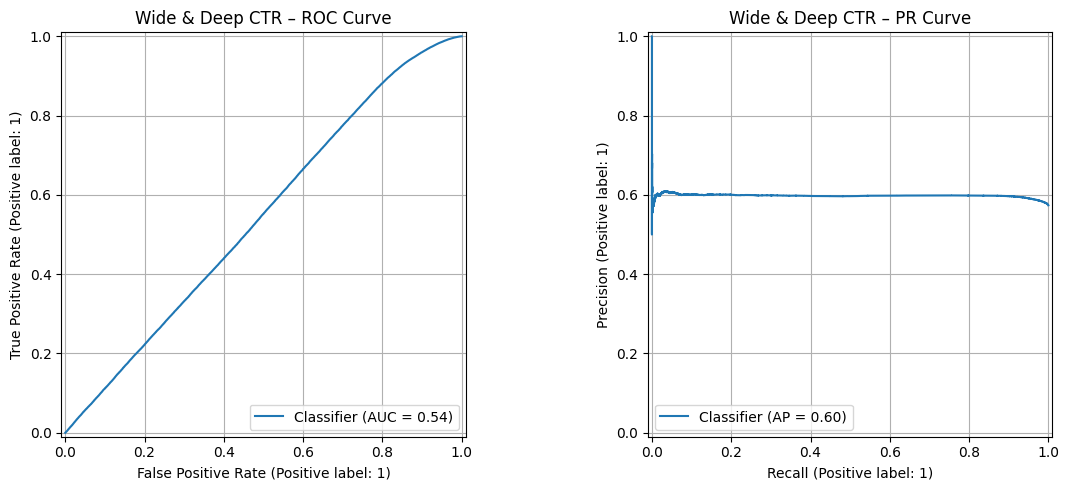

In [24]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

RocCurveDisplay.from_predictions(test_labels, test_probs, ax=ax[0])
ax[0].set_title("Wide & Deep CTR – ROC Curve")

PrecisionRecallDisplay.from_predictions(test_labels, test_probs, ax=ax[1])
ax[1].set_title("Wide & Deep CTR – PR Curve")

plt.tight_layout()
plt.show()